In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import seaborn as sn

In [2]:
os.chdir('/projects/canis/eoc_feature_corr')

In [3]:
grid_path = "data/by_state/MT/mt_extent_1km_grid.shp"
original_grid = gd.read_file(grid_path)
original_grid = original_grid.set_index('id')
grid = original_grid

In [4]:
chg_path = "data/challenger_speed_tests/chg_30_entity_15884_challenger_speed_tests_valid_certified.csv"
chg_data = pd.read_csv(chg_path, parse_dates=['timestamp'])
chg = gd.GeoDataFrame(chg_data, geometry=gd.points_from_xy(chg_data.longitude, chg_data.latitude)).set_crs("EPSG:4326").to_crs(grid.crs)

In [5]:
chg[chg['provider_name'] == 'Verizon Wireless']

,latitude,longitude,timestamp,signal_strength,download_speed,latency,provider_id,provider_name,device_id,masked_device_imei,measurement_method_code,measurement_app_name,measurement_server_location,masked_entity_id,state_fips,grid_col,grid_row,geometry


In [6]:
chg.groupby('provider_name').count()

,latitude,longitude,timestamp,signal_strength,download_speed,latency,provider_id,device_id,masked_device_imei,measurement_method_code,measurement_app_name,measurement_server_location,masked_entity_id,state_fips,grid_col,grid_row,geometry
provider_name,,,,,,,,,,,,,,,,,
AT&T,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624,232624
T-Mobile,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105,232105
Verizon,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564,739564


In [7]:
verizon_path = "data/by_state/MT/mt_extent_verizon.shp"
verizon = gd.read_file(verizon_path).to_crs(grid.crs)

<AxesSubplot:>

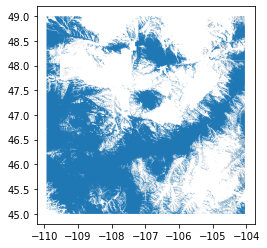

In [8]:
verizon.plot()

In [9]:
# 0 is no signal strength, and in future calculations we consider 
# -120 signal strength to be no signal. As we use median power 
# the impacts to the mean this causes do not matter.
chg['signal_strength'] = chg['signal_strength'].replace(0,-120)

In [10]:
# this lables every point with a grid ID, collecting the grid IDs
# that have extant measurements
chg_grid = gd.sjoin(chg, grid, how='left', op='within')

In [11]:
chg_grid.groupby('index_right').median()['signal_strength']

index_right
585.0      -120.0
586.0      -120.0
1235.0     -120.0
1889.0     -120.0
1895.0     -120.0
            ...  
428560.0   -120.0
428561.0   -120.0
428562.0   -120.0
428563.0   -105.0
428564.0   -120.0
Name: signal_strength, Length: 11898, dtype: float64

In [12]:
grid['med_rxpwr'] = chg_grid.groupby('index_right').median()['signal_strength']
grid = grid.dropna()

In [13]:
original_grid['centroid'] = original_grid['geometry'].centroid
original_grid = original_grid.set_geometry('centroid')
fcc_grid = gd.sjoin(original_grid, verizon, how="left", op="within").dropna()
original_grid = original_grid.set_geometry('geometry')
original_grid = original_grid.drop('centroid', axis=1)

<ipython-input-13-702a72e62e09>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  original_grid['centroid'] = original_grid['geometry'].centroid


In [14]:
grid['chg_coverage'] = grid['med_rxpwr'] > -110
grid['verizon_coverage'] = grid.index.isin(fcc_grid.index)

In [15]:
grid.to_file("./data/by_state/MT/mt_extent_coverage.shp")

In [16]:
grid

,left,top,right,bottom,geometry,med_rxpwr,chg_coverage,verizon_coverage
id,,,,,,,,
585.0,-1.223775e+07,5.690753e+06,-1.223675e+07,5.689753e+06,"POLYGON ((-109.93360 45.43807, -109.92462 45.4...",-120.0,False,False
586.0,-1.223775e+07,5.689753e+06,-1.223675e+07,5.688753e+06,"POLYGON ((-109.93360 45.43177, -109.92462 45.4...",-120.0,False,True
1235.0,-1.223675e+07,5.694753e+06,-1.223575e+07,5.693753e+06,"POLYGON ((-109.92462 45.46328, -109.91563 45.4...",-120.0,False,False
1889.0,-1.223575e+07,5.694753e+06,-1.223475e+07,5.693753e+06,"POLYGON ((-109.91563 45.46328, -109.90665 45.4...",-120.0,False,False
1895.0,-1.223575e+07,5.688753e+06,-1.223475e+07,5.687753e+06,"POLYGON ((-109.91563 45.42546, -109.90665 45.4...",-120.0,False,False
...,...,...,...,...,...,...,...,...
428560.0,-1.158275e+07,6.085753e+06,-1.158175e+07,6.084753e+06,"POLYGON ((-104.04963 47.87300, -104.04065 47.8...",-120.0,False,True
428561.0,-1.158275e+07,6.084753e+06,-1.158175e+07,6.083753e+06,"POLYGON ((-104.04963 47.86697, -104.04065 47.8...",-120.0,False,True
428562.0,-1.158275e+07,6.083753e+06,-1.158175e+07,6.082753e+06,"POLYGON ((-104.04963 47.86095, -104.04065 47.8...",-120.0,False,True


In [17]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [18]:
confusion_matrix = pd.crosstab(grid['chg_coverage'], grid['verizon_coverage'], rownames=['Challenger Cover'], colnames=['FCC 477 Verizon Coverage'])
print (confusion_matrix)

FCC 477 Verizon Coverage  False  True 
Challenger Cover                      
False                      3301   7902
True                        464    231


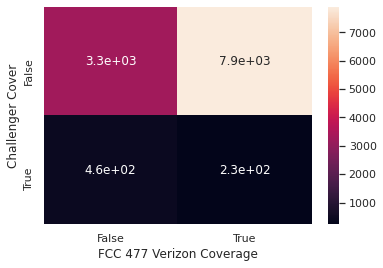

In [19]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()